### Install

In [1]:
!pip install -U --pre tensorflow=="2.*"

Requirement already up-to-date: tensorflow==2.* in /usr/local/lib/python3.6/dist-packages (2.2.0)


Make sure we have `pycocotools` installed

In [2]:
!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [3]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2662, done.
remote: Counting objects: 100% (2662/2662), done.
remote: Compressing objects: 100% (2328/2328), done.
remote: Total 2662 (delta 529), reused 1333 (delta 300), pack-reused 0
Receiving objects: 100% (2662/2662), 32.16 MiB | 29.70 MiB/s, done.
Resolving deltas: 100% (529/529), done.


Compiling protobufs and installing the object_detection package

In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [5]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1113489 sha256=f910c22c0b3c8dc3f4d5c80ca0344a51d077de1b11f60741d6bd3cc81d2fbde5
  Stored in directory: /tmp/pip-ephem-wheel-cache-3j9m1dev/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


### Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Importing the object detection module.

In [0]:
# !wget https://github.com/google-research/tf-slim

In [8]:
!pip3 install tf-slim

     |████████████████████████████████| 358kB 2.8MB/s 


In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

In [0]:
# What model to download.
MODEL_NAME = 'cube_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'object-detection.pbtxt')
PATH_TO_LABELS = os.path.join('/content/models/research/object_detection/data', 'object-detection.pbtxt')

NUM_CLASSES = 1

# object-detection.pbtxt from training to data
# image10.jpg and image11.jpg to test_images

## Loader

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [0]:
!mkdir -p /content/models/research/object_detection/cube_inference_graph

In [0]:
# Upload zip file with the model cube_inference_graph.zip to the cube_inference_graph directory first
!cd /content/models/research/object_detection/cube_inference_graph && unzip -q cube_inference_graph.zip

## Loading label map

In [0]:
# List of the strings that is used to add correct label for each box.
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
# !cd /content/models/research/object_detection
# !dir

In [17]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
# TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(10, 12) ]
TEST_IMAGE_PATHS

['models/research/object_detection/test_images/image10.jpg',
 'models/research/object_detection/test_images/image11.jpg']

# Detection

Loading an object detection model:

In [18]:
detection_model = tf.saved_model.load('/content/models/research/object_detection/' + MODEL_NAME + '/saved_model')
detection_model = detection_model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Checking the model's input signature, it expects a batch of 3-color images of type uint8: 

In [19]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And returns several outputs:

In [20]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'raw_detection_boxes': tf.float32,
 'raw_detection_scores': tf.float32}

In [21]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_multiclass_scores': TensorShape([None, 100, 2]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'raw_detection_boxes': TensorShape([None, None, 4]),
 'raw_detection_scores': TensorShape([None, None, 2])}

Adding a wrapper function to call the model, and cleanup the outputs:

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Running it on each test image and showing the results:

In [0]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2)

  display(Image.fromarray(image_np))

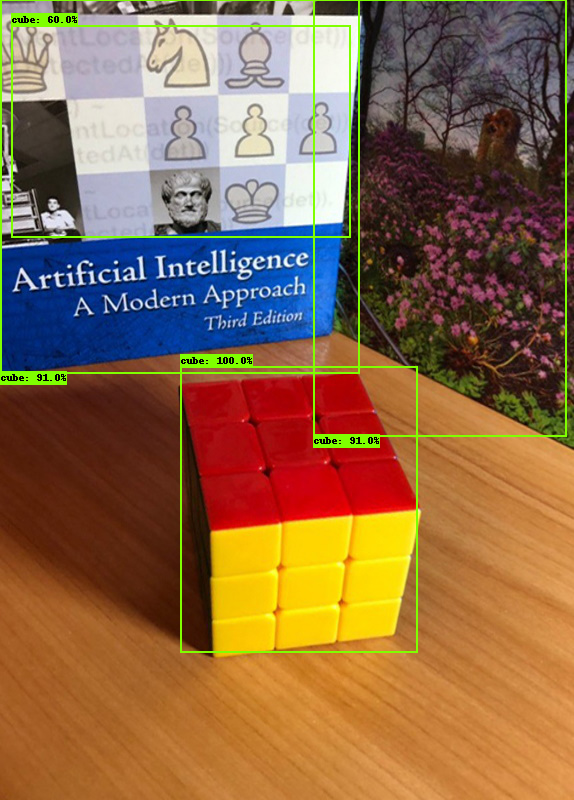

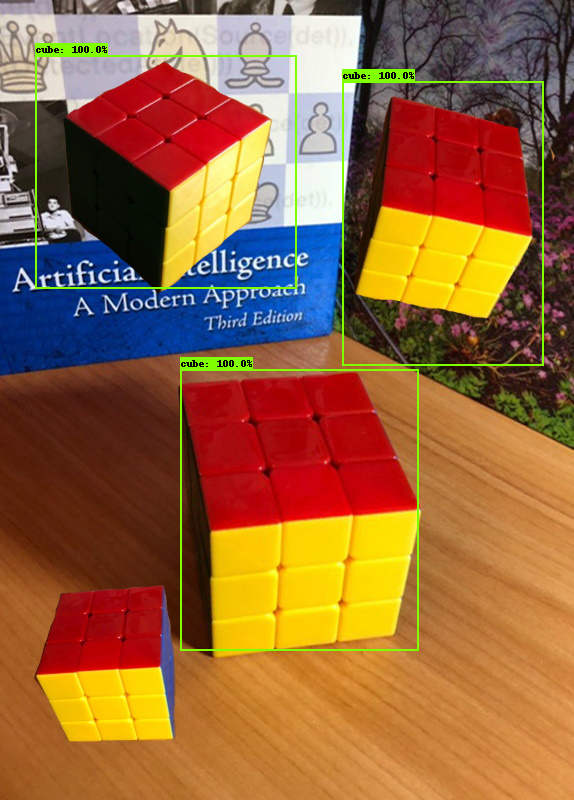

In [24]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

## Instance Segmentation

In [25]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

727392256/727390102 [==============================] - 3s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


The instance segmentation model includes a `detection_masks` output:

In [26]:
masking_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

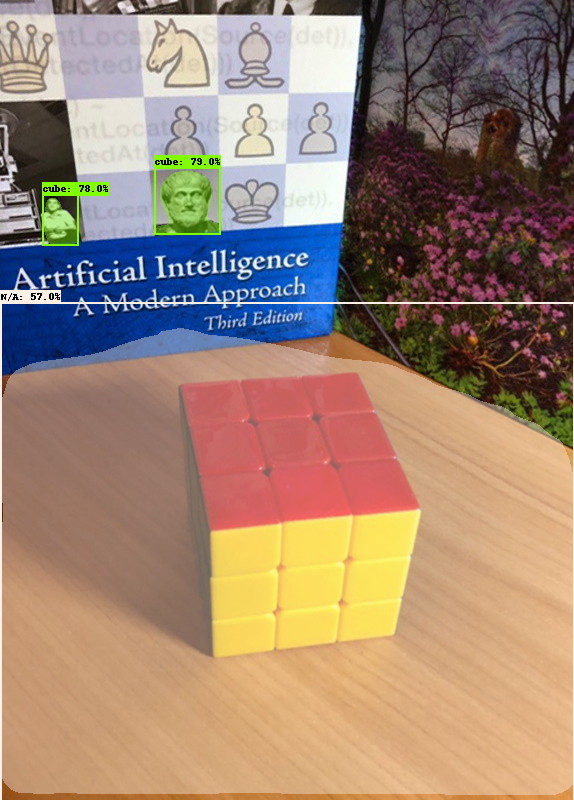

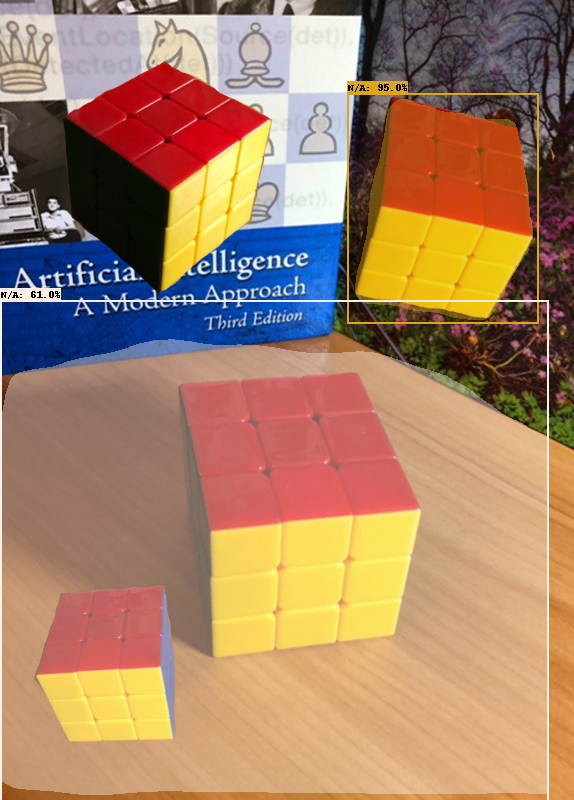

In [27]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)

The result is not very good because of the small number of images for training